In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from typing import List

class MLP(torch.nn.Module):
    def __init__(self, dim_in: int, dim_out: int) -> None:
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim_in, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, dim_out)
        )

    def forward(self, *args):
        y = self.net(torch.concat(args, dim=-1))
        return y

def sample_gaussian(num_samples: int, device: torch.device, mean: float = 0., stddev: float = 1.):
    return torch.normal(mean, torch.full((num_samples, 1), stddev, device=device))

def sample_uniform(num_samples: int, device: torch.device):
    return torch.rand((num_samples, 1), device=device)

def sample_gaussian_mixture(num_samples: int, device: torch.device, means: List[float] = [0.], stddevs: List[float] = [1.]):
    assert len(means) == len(stddevs)
    num_gaussians = len(means)

    # Determine the Gaussian to sample from
    gaussian_index = (num_gaussians * torch.rand(num_samples)).to(dtype=torch.long).clamp_max(num_gaussians - 1)

    return torch.normal(means[gaussian_index], stddevs[gaussian_index])[:, None]

100%|██████████| 2000/2000 [00:07<00:00, 282.67it/s, loss=1.05894]


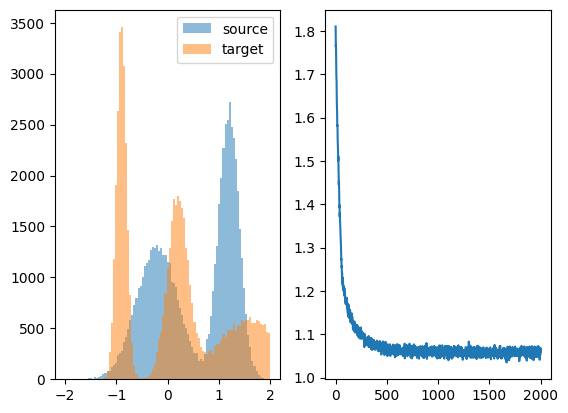

In [2]:
# Training: learn mapping between two simple distributions

# Simpler distributions
# sample_source_distribution = sample_gaussian
# sample_target_distribution = lambda num_samples, device: sample_gaussian(num_samples=num_samples, device=device, mean=0.6, stddev=0.5)

sample_source_distribution = lambda num_samples, device: sample_gaussian_mixture(num_samples, device, means=torch.tensor([-0.2, 1.2], device=device), stddevs=torch.tensor([0.4, 0.2], device=device))
sample_target_distribution = lambda num_samples, device: sample_gaussian_mixture(num_samples, device, means=torch.tensor([-0.9, 0.2, 1.6], device=device), stddevs=torch.tensor([0.1,  0.2, 0.6], device=device))

num_iterations = 2000
num_samples    = 2**16
device         = torch.device('cuda:0')

D = MLP(2, 1).to(device)

optimizer = torch.optim.Adam(D.parameters(), lr=1e-3)

progress_range = tqdm(range(num_iterations))
losses = []
for it in progress_range:
    x_0 = sample_source_distribution(num_samples, device=device)
    x_1 = sample_target_distribution(num_samples, device=device)

    alpha   = torch.rand(num_samples, 1, device=device)
    x_alpha = (1 - alpha) * x_0 + alpha * x_1

    D_output = D(x_alpha, alpha)

    loss = torch.mean((D_output - (x_1 - x_0))**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(float(loss.item()))
    progress_range.set_postfix({"loss": f"{loss.item():0.5f}"})

bins = torch.linspace(-2, 2, 100)
fig, axs = plt.subplots(1, 2)
axs[0].hist(x_0.cpu().numpy(), bins=bins, alpha=0.5, label="source")
axs[0].hist(x_1.cpu().numpy(), bins=bins, alpha=0.5, label="target")
axs[0].legend()
axs[1].plot(losses)
plt.show()

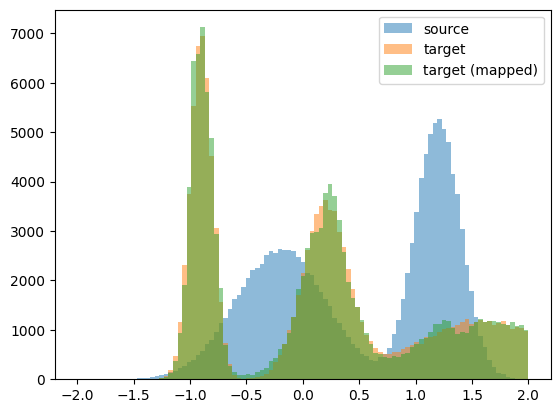

In [3]:
# Sample the target distribution by using samples from the source distribution
num_eval_samples = 2*num_samples

x_0    = sample_source_distribution(num_eval_samples, device=device)
T      = 128
alphas  = torch.linspace(0, 1, T + 1, device=device)
with torch.no_grad():
    x_alpha  = x_0
    x_alphas = [x_alpha]
    for alpha_i, alpha_ii in zip(alphas[:-1], alphas[1:]):
        alpha = alpha_i[None, None].expand_as(x_alpha)
        D_output = D(x_alpha, alpha)
        x_alpha = x_alpha + (alpha_ii - alpha_i) * D_output
        x_alphas.append(x_alpha)

x_1 = sample_target_distribution(num_eval_samples, device=device)

plt.hist(x_0.cpu().numpy(), bins=bins, alpha=0.5, label="source")
plt.hist(x_1.cpu().numpy(), bins=bins, alpha=0.5, label="target")
plt.hist(x_alpha.cpu().numpy(), bins=bins, alpha=0.5, label="target (mapped)")
plt.legend()
plt.show()

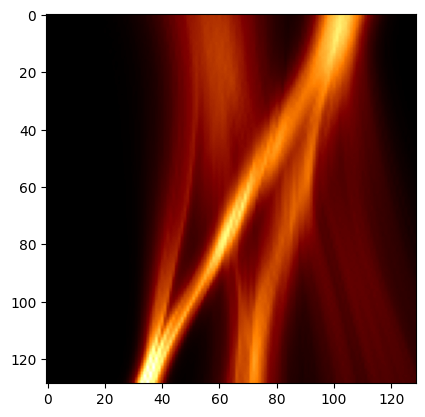

In [4]:
# Visualize the trajectory akin to Figure 9 from the IADB paper
hist_img = torch.stack([torch.histc(x_alphas[i], bins=T+1, min=-2, max=2) for i in range(len(x_alphas))], dim=0)
plt.imshow(hist_img.cpu(), cmap='afmhot')